# 水肿体积随时间变化曲线 拟合+计算残差   
> a)  请根据“表2”前100个患者（sub001至sub100）的水肿体积（ED_volume）和重复检查时间点，构建一条全体患者水肿体积随时间进展曲线   
（x轴：发病至影像检查时间，y轴：水肿体积，y=f(x)），   
计算前100个患者（sub001至sub100）真实值和所拟合曲线之间存在的残差。   
结果填写规范：记录残差，填写位置“表4”F字段（残差（全体））。

（再多算一个131～160上的拟合结果，R^2 / MSE）
模型的选择：
1. 可解释性
2. 泛化性能

## 读入数据   
理论上此处需要使用三个文件：   
- 表1-患者列表及临床信息（用于确定发病时间）
- 表2-患者影像信息血肿及水肿的体积及位置（用于获取每次检查时的肿块体积和检查流水号）
- 附表1-检索表格-流水号vs时间（基于检查流水号获取检查时间点）   

用 Q1a 的中间结果替代时间间隔数据更快一些

In [1]:
import pandas as pd
import math

In [2]:
tab_1 = pd.read_excel('~/shumo/metadata/表1-患者列表及临床信息.xlsx')
tab_1 = tab_1.rename(columns={'Unnamed: 0': 'ID'})

# tab_2 = pd.read_excel('~/shumo/metadata/表2-患者影像信息血肿及水肿的体积及位置.xlsx')

ann_tab = pd.read_excel('~/shumo/metadata/附表1-检索表格-流水号vs时间(1).xlsx')

In [3]:
# 沿用 Q1a 的处理代码获取 ED_volume
tab2_dict = {}
for i, sheet_name in enumerate(['首次', '随访1', '随访2', '随访3', '随访4', '随访5', '随访6', '随访7', '随访8']):
    if sheet_name == '首次':
        col = '首次检查流水号'
    else:
        col = sheet_name + '流水号'

    tab2_dict[i] = pd.read_excel('~/shumo/metadata/表2-患者影像信息血肿及水肿的体积及位置.xlsx', sheet_name=sheet_name, usecols=['ID', col, 'HM_volume', 'ED_volume'])

In [4]:
# 从 Q1a 获取一个中间结果：包含发病时间和每次检查的时间间隔
tab2_cmp = pd.read_excel("~/shumo/Q1/Q1a/processed/Q1a_record.xlsx", usecols=['ID', 'interval_1', 'interval_2','interval_3','interval_4','interval_5','interval_6','interval_7','interval_8'])

In [5]:
tab2_cmp

,ID,interval_1,interval_2,interval_3,interval_4,interval_5,interval_6,interval_7,interval_8
0,sub001,8.268333,132.108333,259.737500,425.538333,NaN,NaN,NaN,NaN
1,sub002,14.923333,69.221944,448.016389,1119.191944,NaN,NaN,NaN,NaN
2,sub003,9.522500,39.595833,NaN,NaN,NaN,NaN,NaN,NaN
3,sub004,16.974167,83.845278,227.501111,NaN,NaN,NaN,NaN,NaN
4,sub005,26.467500,97.943056,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
155,sub156,24.881944,125.615833,293.317222,NaN,NaN,NaN,NaN,NaN
156,sub157,1.366667,7.116667,20.066667,NaN,NaN,NaN,NaN,NaN
157,sub158,18.383333,71.300000,308.650000,NaN,NaN,NaN,NaN,NaN
158,sub159,26.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 获取每个时间点下的水肿体积

In [7]:
# 获得每个病人每次测量的水肿体积和对应时间间隔（指从发病到该次检测的时间间隔）
# Q2d的时候不限制患者数量

patient_ED_dict = dict()
# 同时获取一下血肿体积
patient_HM_dict = dict()

for patient in tab_1["ID"].tolist():
    
    patient_ED_dict[patient] = []
    patient_HM_dict[patient] = []
    
    # 获取时间间隔
    first_interval = tab_1.loc[tab_1["ID"] == patient]["发病到首次影像检查时间间隔"].values[0]
    interval_time = [first_interval] + tab2_cmp.loc[tab2_cmp['ID'] == patient].values.tolist()[0][1:]
    
    # 获取每次的水肿数量
    for check in range(9): # 最多只有1次检查+8次随访记录
        
        ed_v = tab2_dict[check].loc[tab2_dict[check]["ID"] == patient].values[0][3]
        hm_v = tab2_dict[check].loc[tab2_dict[check]["ID"] == patient].values[0][2]
        
        # 如果此次随访已没有记录则跳出
        if pd.isna(ed_v):
            break
        
        ed_v = ed_v
        hm_v = hm_v
        patient_ED_dict[patient].append((interval_time[check], ed_v))
        patient_HM_dict[patient].append((interval_time[check], hm_v))

In [98]:
# 保存数据
# pd.to_pickle(patient_ED_dict, "patient_ED_dict.pkl")

### 测试集

In [351]:
# 计算前 131~160 个患者

patient_ED_test_dict = dict()
# 同时获取一下血肿体积
patient_HM_test_dict = dict()

for patient in tab_1["ID"].tolist()[132:]:
    
    patient_ED_test_dict[patient] = []
    patient_HM_test_dict[patient] = []
    
    # 获取时间间隔
    first_interval = tab_1.loc[tab_1["ID"] == patient]["发病到首次影像检查时间间隔"].values[0]
    interval_time = [first_interval] + tab2_cmp.loc[tab2_cmp['ID'] == patient].values.tolist()[0][1:]
    
    # 获取每次的水肿数量
    for check in range(9): # 最多只有1次检查+8次随访记录
        
        ed_v = tab2_dict[check].loc[tab2_dict[check]["ID"] == patient].values[0][3]
        hm_v = tab2_dict[check].loc[tab2_dict[check]["ID"] == patient].values[0][2]
        
        # 如果此次随访已没有记录则跳出
        if pd.isna(ed_v):
            break
        
        ed_v = ed_v
        hm_v = hm_v
        patient_ED_test_dict[patient].append((interval_time[check], ed_v))
        patient_HM_test_dict[patient].append((interval_time[check], hm_v))

## 时序数据可视分析

In [ ]:
patient_ED_dict = pd.read_pickle(patient_ED_dict, "patient_ED_dict.pkl")

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import numpy as np

In [12]:
time = []
vol = []
hm_vol = []
for person in patient_ED_dict:
    seq = patient_ED_dict[person]
    seq_hm = patient_HM_dict[person]
    # 时间间隔
    time += [i[0] for i in seq]
    # 体积
    vol += [i[1] / 1000 for i in seq] # 单位统一到 ml
    # 血肿体积
    hm_vol += [i[1] / 1000 for i in seq_hm]

In [13]:
# 测试集
time_test = []
vol_test = []
hm_test = []
for person in patient_ED_test_dict:
    seq = patient_ED_test_dict[person]
    seq_hm = patient_HM_test_dict[person]
    # 时间间隔
    time_test += [i[0] for i in seq]
    # 体积
    vol_test += [i[1] / 1000 for i in seq] # 单位统一到 ml
    # 血肿体积
    hm_test += [i[1] / 1000 for i in seq_hm]

NameError: name 'patient_ED_test_dict' is not defined

In [14]:
%matplotlib inline

In [15]:
# 设置全局字体大小
plt.rcParams['font.size'] = 16

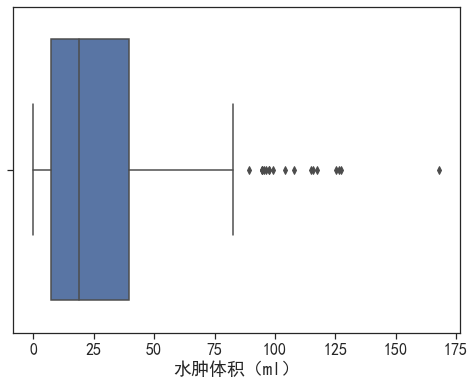

In [477]:
# 单变量分析：水肿的分布
plt.close()

plt.figure(figsize=(8, 6))
sns.boxplot(x=vol)
plt.xlabel('水肿体积（ml）', fontsize=18)
plt.xticks(fontsize=16)
# plt.ylabel('分布频率')

plt.savefig('img/水肿体积_箱型图.pdf', dpi=300, bbox_inches='tight')

plt.show()

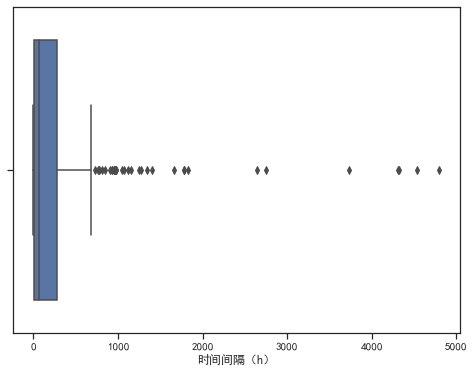

In [64]:
# 单变量分析：水肿的分布
plt.close()

plt.figure(figsize=(8, 6))
sns.boxplot(x=time)
plt.xlabel('时间间隔（h）')
# plt.ylabel('分布频率')

plt.show()

In [15]:
# 计算条形图相关参数
mean = np.mean(vol)  # 平均值
median = np.median(vol)  # 中位数
std = np.std(vol)  # 标准差
min_value = np.min(vol)  # 最小值
max_value = np.max(vol)  # 最大值

# 输出条形图相关参数
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)
print("Min Value:", min_value)
print("Max Value:", max_value)

Mean: 26.561
Median: 18.988999999999997
Standard Deviation: 26.065960710900764
Min Value: 0.0
Max Value: 168.138


In [16]:
# 分样本散点图
pat = [i+1 for i in range(100)]

y_seq = [] # y轴数据是患者序号
time_seq = [] # 仍然作为 y轴
val_seq = [] # 作为散点的数值存在

for person in patient_ED_dict:
    seq = patient_ED_dict[person]
    # 时间间隔
    time_seq += [i[0] for i in seq]
    # 体积
    val_seq += [i[1] / 1000 for i in seq] # 单位统一到 ml
    # 患者序号
    y_seq += [int(person[3:]) for i in range(len(seq))]

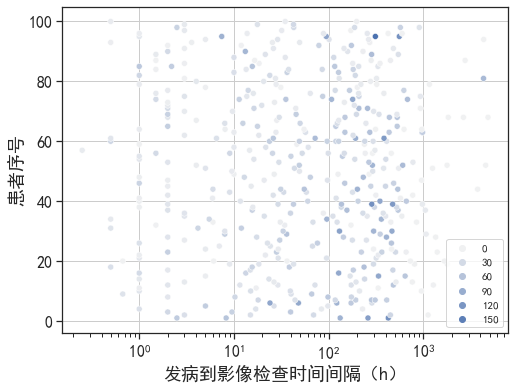

In [478]:
# 双变量分析：分样本散点图
# 横坐标 检测到发病的时间点
# 纵坐标 患者序号
# 散点颜色 水肿体积（ml）
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))

sns.color_palette("light:b", as_cmap=True)

sns.scatterplot(x=time_seq, y=y_seq, hue=val_seq, palette='light:b')

plt.xscale('log')
plt.grid(True)
plt.xlabel("发病到影像检查时间间隔（h）", fontsize=18)
plt.ylabel("患者序号", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/患者水肿体积分布.pdf', dpi=300, bbox_inches='tight')

plt.show()

从图中可以大致看出发病后 100h 后水肿体积开始明显增大   
下图将所有患者的数据混合

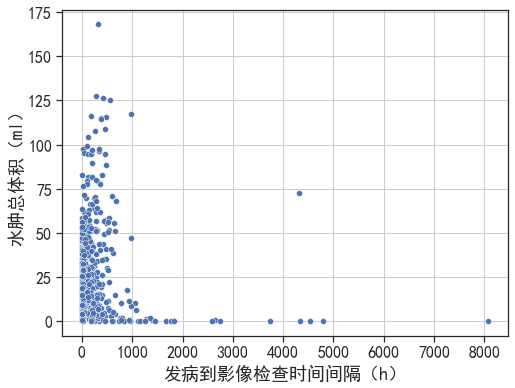

In [17]:
# 双变量分析：综合散点图
# 横坐标 检测到发病的时间点
# 纵坐标 检测时对应的水肿体积（ml）
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol)
# sns.lineplot(x=time, y=vol, alpha=0.2)
plt.grid(True)
plt.xlabel("发病到影像检查时间间隔（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
# plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('img/患者水肿体积分布_总体.pdf', dpi=300, bbox_inches='tight')

plt.show()

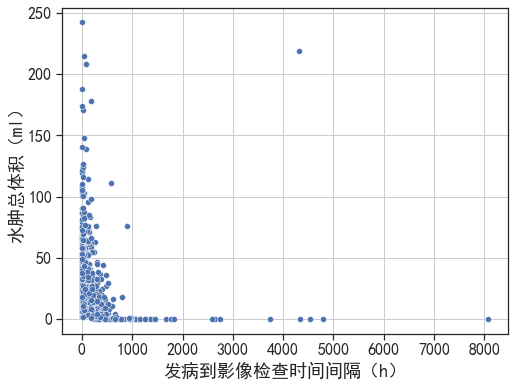

In [18]:
# 双变量分析：综合散点图
# 横坐标 检测到发病的时间点
# 纵坐标 检测时对应的水肿体积（ml）
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=hm_vol)
# sns.lineplot(x=time, y=vol, alpha=0.2)
plt.grid(True)
plt.xlabel("发病到影像检查时间间隔（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
# plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('img/患者水肿体积分布_总体.pdf', dpi=300, bbox_inches='tight')

plt.show()

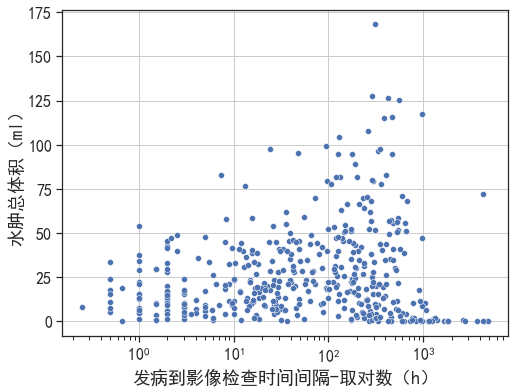

In [480]:
# 横轴取 log 之后，与分样本观察的规律一致
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol)

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/患者水肿体积分布_总体_时间对数.pdf', dpi=300, bbox_inches='tight')

plt.show()

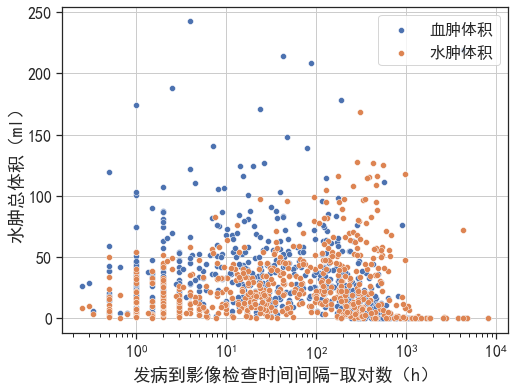

In [24]:
# 横轴取 log 之后，与分样本观察的规律一致
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))

sns.scatterplot(x=time, y=hm_vol, label="血肿体积")
sns.scatterplot(x=time, y=vol, label="水肿体积")

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.savefig('img/患者血肿水肿体积分布_时间对数.pdf', dpi=300, bbox_inches='tight')

plt.show()

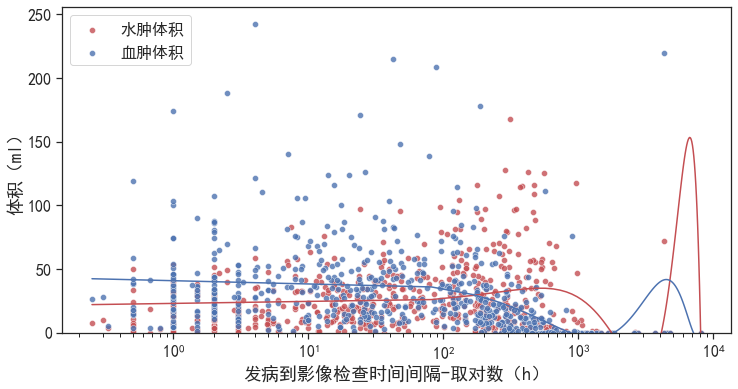

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
x = np.array(time)
y = np.array(vol)

x2 = np.array(time)
y2 = np.array(hm_vol)

plt.figure(figsize=(12, 6))
# 多项式拟合
degree = 4  # 多项式的阶数
coefficients = np.polyfit(x, y, degree)
p = np.poly1d(coefficients)

coefficients2 = np.polyfit(x2, y2, degree)
p2 = np.poly1d(coefficients2)

# 绘制散点图
sns.scatterplot(x=time, y=vol, label="水肿体积", color="r", alpha=0.8)
sns.scatterplot(x=time, y=hm_vol, label="血肿体积", color="b", alpha=0.8)

# 绘制水肿曲线
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = np.polyval(coefficients, x_fit)
plt.plot(x_fit, y_fit, 'r')

# 绘制血肿曲线
x_fit2 = np.linspace(x2.min(), x2.max(), 100)
y_fit2 = np.polyval(coefficients2, x_fit2)
plt.plot(x_fit2, y_fit2, 'b')

# 添加标题和标签
plt.xscale('log')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0, None)

plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("体积（ml）", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.savefig('img/患者血肿水肿体积分布_时间对数.pdf', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

说明水肿与发病时间间隔间应该存在潜在关联，并且是较为普适的。   
下面进行回归分析

## 数据预处理-去除离群点

In [126]:
# 数据转为 ndarray
time_np = np.array(time).reshape(-1, 1)
vol_np = np.array(vol).ravel()
hm_vol_np = np.array(hm_vol).ravel()

# 剩下的正常数据
# time_res = [i[0] for i in reserve_data]
# vol_res = [i[1] for i in reserve_data]

# time_np_res = np.array(time_res).reshape(-1, 1)
# vol_np_res = np.array(vol_res).ravel()

In [127]:
# 对原始数据进行排序
new_index = np.argsort(time_np, axis=0)
time_sorted = time_np[new_index].reshape(-1, 1)
vol_sorted = vol_np[new_index].reshape(-1, 1)
hm_vol_sorted = hm_vol_np[new_index].reshape(-1, 1)

In [353]:
# 测试集
time_test_np = np.array(time_test).reshape(-1, 1)
vol_test_np = np.array(vol_test).ravel()
hm_test_np = np.array(hm_test).ravel()

new_index = np.argsort(time_test_np, axis=0)
time_test_sorted = time_test_np[new_index].reshape(-1, 1)
vol_test_sorted = vol_test_np[new_index].reshape(-1, 1)
hm_test_sorted = hm_test_np[new_index].reshape(-1, 1)

### 基于时间：根据其他论文的结论截取前60天   
即1440小时以内的数据   
排序之后 第438是1397h，第439是1668h（超出了）。**保留到** 438 即可

In [128]:
# 保留指定时间下的数据
time_sorted_res = time_sorted[:439]
vol_sorted_res = vol_sorted[:439]
hm_sorted_res = hm_vol_sorted[:439]

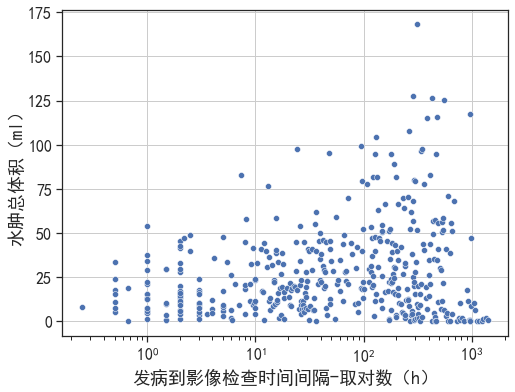

In [481]:
# 将日期截断之后的数据进行可视化
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_sorted_res.flatten(), y=vol_sorted_res.flatten())

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
plt.xscale('log')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/患者水肿体积分布_截断时间.pdf', dpi=300, bbox_inches='tight')

plt.show()

### 基于密度的方法-LOF

（可以可视化样本点）

In [1]:
from sklearn.neighbors import LocalOutlierFactor

In [131]:
zip_feat = list(zip(time_sorted_res.flatten(), vol_sorted_res.flatten()))

In [246]:
# 创建LOF模型
# 剔除10%的异常样本点
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

y_pred_lof = lof.fit_predict(zip_feat)

# 获取样本的异常值得分
scores = lof.negative_outlier_factor_

# 打印样本的异常值得分和预测结果
formal_data = []
for i, (score, pred) in enumerate(zip(scores, y_pred_lof)):
    if pred == 1:
        formal_data.append([zip_feat[i][0], zip_feat[i][1], hm_sorted_res[i].item()])

In [247]:
time_sorted_formal = [i[0] for i in formal_data]
vol_sorted_formal = [i[1] for i in formal_data]
hm_sorted_formal = [i[2] for i in formal_data]

time_formal_np = np.array(time_sorted_formal).reshape(-1, 1)
vol_formal_np = np.array(vol_sorted_formal).reshape(-1, 1)
hm_formal_np = np.array(hm_sorted_formal).reshape(-1, 1)

In [248]:
# 对正常数据进行排序（前面排过，这里不用排了）
# new_index = np.argsort(time_np_res, axis=0)
# time_sorted_res = time_np_res[new_index].reshape(-1, 1)
# vol_sorted_res = vol_np_res[new_index].reshape(-1, 1)
print("异常点数量")
print(time_formal_np.shape)

异常点数量
(417, 1)


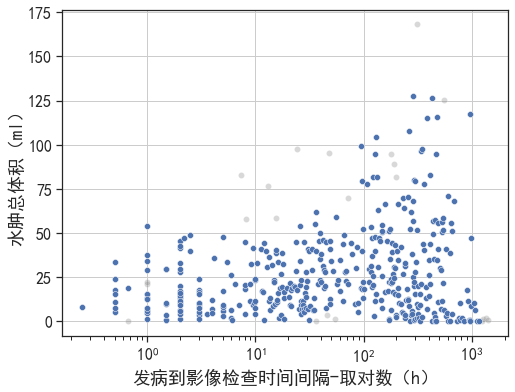

In [482]:
# 可视化异常点
plt.close()

plt.figure(figsize=(8, 6))

sns.scatterplot(x=time_sorted_res.flatten(), y=vol_sorted_res.flatten(), alpha=0.3, color="gray")
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten())

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("水肿总体积（ml）", fontsize=18)
plt.xscale('log')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/患者水肿体积分布_去除异常点.pdf', dpi=300, bbox_inches='tight')

plt.show()

## 时序数据回归分析   
样本点数量：450   
截断+排除异常点后的数据

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

### 传统回归分析   
1. 线性回归模型
2. 多项式回归模型
3. 非线性回归模型
    - 指数函数
    - 对数函数
    - 幂函数
4. 广义线性模型
    - 线性回归
    - 逻辑回归
    - 泊松回归

In [413]:
from sklearn.ensemble import GradientBoostingRegressor

#### 线性回归

In [484]:
# 线性回归
linear_model = LinearRegression()
linear_model.fit(time_formal_np, vol_formal_np)

y_pred = linear_model.predict(time_formal_np)

# y_pred_test = linear_model.predict(time_test_np)

# 计算均方误差
# residuals = vol_sorted - y_pred
mse = mean_squared_error(vol_formal_np, y_pred)
r2 = r2_score(vol_formal_np, y_pred)
# print("残差：", residuals)
print("1~100")
print("均方误差：", mse)
print("R2:", r2)

y_pred_test = linear_model.predict(time_test_np)
mse = mean_squared_error(vol_test_np, y_pred_test)
r2 = r2_score(vol_test_np, y_pred_test)
print("131~160")
print("均方误差：", mse)
print("R2:", r2)

1~100
均方误差： 548.613334992961
R2: 0.006995856408935075
131~160
均方误差： 735.5651901409218
R2: -0.13381647685275255


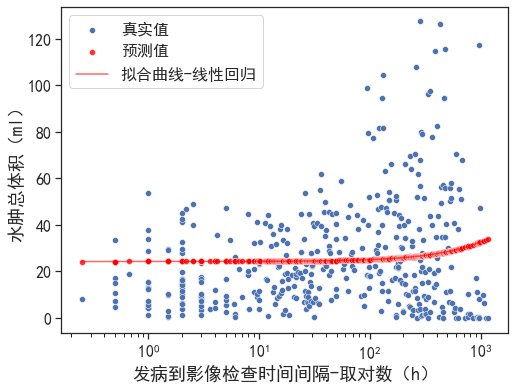

In [485]:
# 绘制回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred.flatten(), color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-线性回归', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_线性回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

#### 多项式回归

In [557]:
# 多项式回归

mse_l = []
r2_l = []

def poly_linear_r(degree, test=False):
    poly_feat = PolynomialFeatures(degree=degree)
    train_feat = poly_feat.fit_transform(time_formal_np)
    test_feat = poly_feat.fit_transform(time_test_np)

    # 创建线性回归模型
    linear_model = LinearRegression()

    # 训练模型
    linear_model.fit(train_feat, vol_formal_np)

    y_pred = linear_model.predict(train_feat)
    
    if test:
        y_pred_test = linear_model.predict(test_feat)
        mse = mean_squared_error(vol_test_np, y_pred_test)
        r2 = r2_score(vol_test_np, y_pred_test)
        return mse, r2, y_pred_test
    
    coefficients = linear_model.coef_
    intercept = linear_model.intercept_

    print("回归系数：", coefficients)
    print("截距：", intercept)
    
    # 计算指标
    mse = mean_squared_error(vol_formal_np, y_pred)
    r2 = r2_score(vol_formal_np, y_pred)
    
    return (model, mse, r2, linear_model)

In [ ]:
for d in range(1, 10):
    mse, r2, _, _ = poly_linear_r(d)
    mse_l.append(mse)
    r2_l.append(r2)

<Figure size 576x432 with 0 Axes>

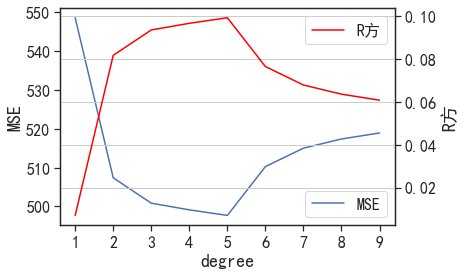

In [526]:
# degree参数挑选
plt.close()

plt.figure(figsize=(8, 6))

degree_range = [d for d in range(1, 10)]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# mse 线
sns.lineplot(x=degree_range, y=mse_l, ax=ax1, label="MSE")
ax1.set_ylabel('MSE', fontsize=18)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
# r2 线
sns.lineplot(x=degree_range, y=r2_l, ax=ax2, color='red', label="R方")

plt.grid(True)
ax2.set_ylabel('R方', fontsize=18)
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

ax1.set_xlabel('degree', fontsize=18)
# plt.ylabel('y')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.legend(fontsize=16, loc="lower right")
ax2.legend(fontsize=16, loc="upper right")

plt.savefig('img/水肿拟合_多项式回归_参数选择.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [558]:
mse, r2, y_pred, final_model = poly_linear_r(4)

回归系数： [[ 0.00000000e+00  1.70906774e-01 -5.04250422e-04  5.40316399e-07
  -2.09564358e-10]]
截距： [17.51249354]


In [512]:
vol_formal_np[-10:]
time_formal_np[-10:]

array([[ 951.54944444],
       [ 956.02166667],
       [ 960.65416667],
       [ 968.34583333],
       [ 975.09666667],
       [ 978.01333333],
       [1047.59194444],
       [1068.37611111],
       [1119.19194444],
       [1155.19138889]])

In [497]:
# d=4
print("mse:", mse, "\tr2:", r2)

mse: 499.1134654858518 	r2: 0.09659188405271646


In [494]:
# d=5
print("mse:", mse, "\tr2:", r2)

mse: 497.67678722880567 	r2: 0.09919230837939153


In [256]:
# d=5
print("mse:", mse, "\tr2:", r2)

mse: 497.67678722880567 	r2: 0.09919230837939153


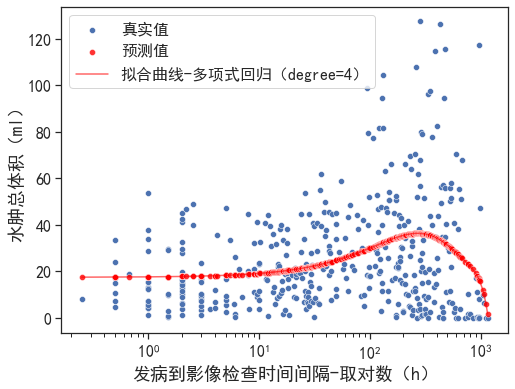

In [498]:
# 绘制多元回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred.flatten(), color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-多项式回归（degree=4）', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.ylabel('水肿总体积（ml）', fontsize=18)
plt.xscale('log')

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_多项式回归_度4.pdf', dpi=300, bbox_inches='tight')

plt.show()

#### 计算Q2b答案

In [577]:
def get_residual(model, patient_data):
    """
    根据输入的回归模型、特征、标签计算残差
    """
    
    # 时间间隔
    test_time = [i[0] for i in patient_data]
    # 体积
    test_vol = [i[1] / 1000 for i in patient_data] # 单位统一到 ml
    
    test_feat = np.array(test_time).reshape(-1, 1)
    test_label = np.array(test_vol).ravel()
    
    poly_feat = PolynomialFeatures(degree=4)
    test_feat = poly_feat.fit_transform(test_feat)
    
    test_pred = model.predict(test_feat)
    
    # print(test_pred)
    # print(test_vol)
    
    residuals = test_vol - test_pred.flatten()
    
    return np.mean(residuals)

In [550]:
patient_ED_dict['sub001']

[(2.5, 48919),
 (8.268333333333334, 57898.0),
 (132.1083333333333, 81747.0),
 (259.7375, 107793.0),
 (425.5383333333334, 126558.0)]

In [48]:
for patient in patient_ED_dict:
    print(patient)
    print(get_residual(final_model, patient_ED_dict[patient]))

sub001


NameError: name 'get_residual' is not defined

In [579]:
ans

56.70467655031371

In [588]:
# 全量数据集上的残差
poly_feat = PolynomialFeatures(degree=4)
test_feat = poly_feat.fit_transform(time_np)

test_pred = final_model.predict(test_feat)

In [598]:
vol_np.shape

(450,)

In [600]:
residuals.shape

(450,)

In [599]:
residuals = vol_np - test_pred.flatten()

In [605]:
min(residuals)

-36.22746344179679

In [607]:
min(test_pred)

array([-62344.17204037])

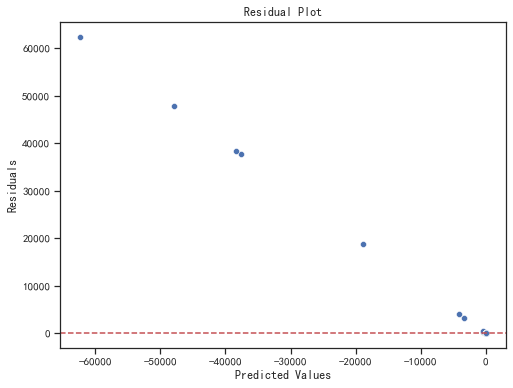

In [608]:
# 绘制残差图
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_pred.flatten(), y=residuals.flatten())
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.show()

#### 指数回归

In [499]:
# 指数回归
time_sorted_transformed = np.log(time_formal_np)

exp_model = LinearRegression()
exp_model.fit(time_sorted_transformed, vol_formal_np)

y_pred = linear_model.predict(time_sorted_transformed)

# 计算均方误差
# residuals = vol_sorted - y_pred
mse = mean_squared_error(vol_formal_np, y_pred)
r2 = r2_score(vol_formal_np, y_pred)
# print("残差：", residuals)
print("均方误差：", mse)
print("R2:", r2)

均方误差： 554.2760832018331
R2: -0.003253862431010779


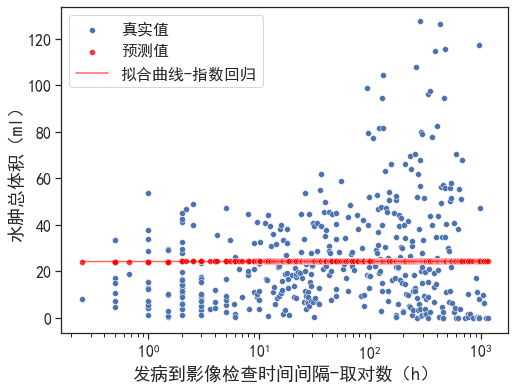

In [501]:
# 绘制回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred.flatten(), color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-指数回归', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_指数回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

#### 对数回归

In [502]:
# 指数回归
vol_sorted_transformed = np.log(vol_formal_np + 1e-10)

log_model = LinearRegression()
log_model.fit(time_formal_np, vol_sorted_transformed)

y_pred = linear_model.predict(time_formal_np)
# 转换预测结果
# y_pred = np.exp(y_pred_log)

# 计算均方误差
# residuals = vol_sorted - y_pred
mse = mean_squared_error(vol_formal_np, y_pred)
r2 = r2_score(vol_formal_np, y_pred)
# print("残差：", residuals)
print("均方误差：", mse)
print("R2:", r2)

均方误差： 548.613334992961
R2: 0.006995856408935075


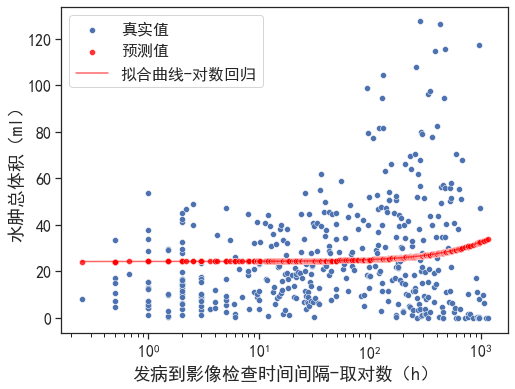

In [503]:
# 绘制回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred.flatten(), color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-对数回归', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_对数回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

指数和对数 应该不太行，因为这两个变量之间指数或对数关系不是特别明显

#### 最小二乘回归

In [55]:
from scipy.optimize import curve_fit

In [504]:
# 定义幂函数模型
def power_func(x, a, b):
    return a * np.power(x, b)

# 使用最小二乘法进行幂函数回归
params, params_covariance = curve_fit(power_func, time_formal_np.flatten(), vol_formal_np.flatten())

# 提取回归参数
a = params[0]
b = params[1]

In [505]:
y_pred = power_func(time_formal_np.flatten(), a, b)

mse = mean_squared_error(vol_formal_np, y_pred)
r2 = r2_score(vol_formal_np, y_pred)

print("均方误差：", mse)
print("R2:", r2)

均方误差： 520.7625068785677
R2: 0.05740656638628161


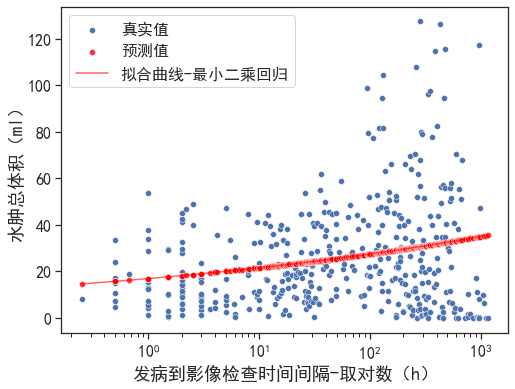

In [507]:
# 绘制回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred.flatten(), color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-最小二乘回归', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_最小二乘回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

#### ARIMA模型

In [278]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
# from statsmodels.tsa.arima.model import auto_arima
# from arch import arch_model
# 查看数据集
# import statsmodels.api as sm

In [305]:
from statsmodels.tsa.stattools import adfuller

In [279]:
data_df = pd.DataFrame({"time":time_formal_np.flatten(), "vol":vol_formal_np.flatten()})

In [298]:
def try_arima(p, d, q):
    # 创建ARIMA模型对象
    arima_model = ARIMA(data_df.vol, order=(p, d, q))

    # 拟合模型
    model_fit = arima_model.fit()

    # 进行预测
    predict = model_fit.predict(start=0, end=416)
    
    mse = mean_squared_error(data_df.vol, predict)
    r2 = r2_score(data_df.vol, predict)
    
    return predict, mse, r2
    # return mse # 这个在grid search的时候用

In [290]:
import tqdm

In [295]:
# Grid Search
mse_dict = dict()

for p in tqdm.tqdm(range(0, 10)):
    for d in range(0, 2):
        for q in range(0, 10):
            mse_dict[(p, d, q)] = try_arima(p, d, q)

  0%|          | 0/10 [00:00<?, ?it/s]/home/yangxs/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yangxs/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yangxs/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yangxs/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/

LinAlgError: LU decomposition error.

In [297]:
# 获取最优参数组
min_item = min(mse_dict, key=mse_dict.get)
# 输出最优参数及对应的 mse
print(min_item, mse_dict[min_item])
# (7, 0, 8), mse=457.3727933686476
# r2 = 0.1721435663121198

(7, 0, 8) 457.3727933686476


In [535]:
# 使用最优参数组下的 arima 模型
arima_predict, mse, r2 = try_arima(7, 0, 8)

/home/yangxs/.local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


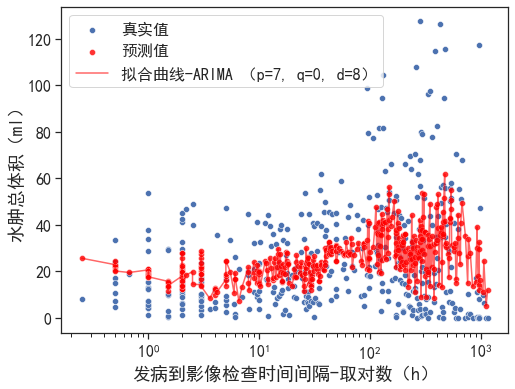

In [536]:
# 绘制 arima 回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=arima_predict, color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), arima_predict, color='red', label='拟合曲线-ARIMA （p=7, q=0, d=8）', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_ARIMA.pdf', dpi=300, bbox_inches='tight')

plt.show()

### 机器学习

In [303]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#### 支持向量回归

rbf会过拟合；深度学习方法一律排除   
rbf的R^2会到0.94

In [305]:
# 随机测试一组参数
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(time_formal_np, vol_formal_np.ravel())

y_pred = svr.predict(time_formal_np)
r2 = r2_score(vol_formal_np, y_pred)
print("R2 Score:", r2)

R2 Score: 0.6643573919129002


In [306]:
# 网格搜索
grid = {'C': [1e2, 1e3, 1e4, 1e5],
              'gamma': [0.01, 0.1, 1, 10,100]}

svr = SVR(kernel='rbf')

grid_search = GridSearchCV(svr, grid, scoring='r2')
grid_search.fit(time_formal_np, vol_formal_np.ravel())

# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Parameters:  {'C': 100.0, 'gamma': 0.1}
Best R2 Score:  -0.268136718431557


In [533]:
# 最优参数过拟合
svr = SVR(kernel='rbf', C=100, gamma=100)
svr.fit(time_formal_np, vol_formal_np.ravel())

y_pred = svr.predict(time_formal_np)
mse = mean_squared_error(vol_formal_np, y_pred)
r2 = r2_score(vol_formal_np, y_pred)

print("mse", mse)
print("R2 Score:", r2)

mse 38.35089282989182
R2 Score: 0.930583904798836


In [214]:
svr = SVR(kernel='rbf', C=1e4, gamma=0.1)
svr.fit(time_np, vol_np)

y_pred = svr.predict(time_np)
r2 = r2_score(vol_np, y_pred)
print("R2 Score:", r2)

R2 Score: 0.6954199731083057


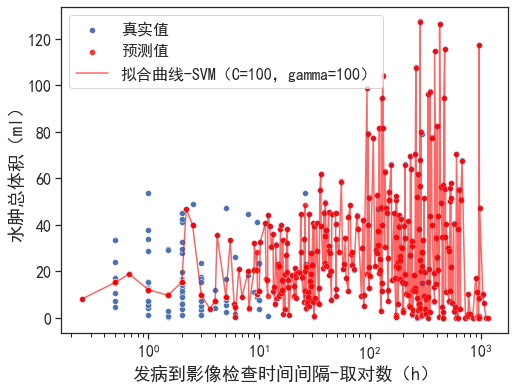

In [534]:
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred, color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-SVM（C=100，gamma=100）', alpha=0.6)
plt.xlabel('发病到影像检查时间间隔-取对数（h）', fontsize=18)
plt.xscale('log')
plt.ylabel('水肿总体积（ml）', fontsize=18)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/水肿拟合_SVM.pdf', dpi=300, bbox_inches='tight')

plt.show()

## 根据论文，假设EED与水肿体积之间的关系

In [381]:
import math

In [319]:
# 计算 eed
def get_eed(ed_vol, hm_vol):
    term_1 = ((3 * (ed_vol + hm_vol) / (4 * np.pi)) ** (1/3))
    term_2 = ((3 * (hm_vol) / (4 * np.pi)) ** (1/3))
    return term_1 - term_2

In [320]:
# 单位为 cm
vol_sorted_eed = get_eed(vol_formal_np.flatten(), hm_formal_np.flatten())

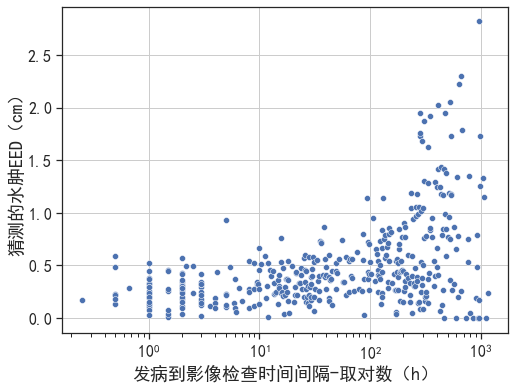

In [538]:
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_sorted_eed.flatten())

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("猜测的水肿EED（cm）", fontsize=18)
plt.xscale('log')

# plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/EED_分布图.pdf', dpi=300, bbox_inches='tight')

plt.show()

### 非线性最小二乘

In [466]:
from scipy.optimize import curve_fit

In [539]:
# 最小二乘回归

# 定义幂函数模型
def power_func(x, a, b):
    return a * np.power(x, b)

In [540]:
# 使用最小二乘法进行幂函数回归
params, params_covariance = curve_fit(power_func, time_formal_np.flatten(), vol_sorted_eed)

# 提取回归参数
a = params[0]
b = params[1]

In [541]:
print("a:", a, "b:", b)

a: 0.18016599172582867 b: 0.23613895684497155


In [542]:
y_pred = power_func(time_formal_np.flatten(), a, b)

In [543]:
mse = mean_squared_error(vol_sorted_eed, y_pred)
r2 = r2_score(vol_sorted_eed, y_pred)
print(mse, r2)

0.13626332656740955 0.23828056919807739


In [512]:
# mse = mean_squared_error(vol_sorted_eed, y_pred)

In [544]:
y_pred_vol = (4*np.pi/3) * ((y_pred + (hm_formal_np.flatten() / (4*np.pi/3))**(1/3) )**3) - hm_formal_np.flatten()

In [545]:
y_pred_vol[:10]

array([ 5.93952945, 11.89279092,  5.53874211,  9.10474416,  4.77857874,
        9.61720907,  4.89211818,  9.05740692, 10.2196861 , 16.46735297])

In [453]:
mse = mean_squared_error(vol_formal_np, y_pred_vol)

In [454]:
r2 = r2_score(vol_formal_np, y_pred_vol)

In [455]:
r2

0.0934210351482192

In [456]:
mse

500.86529099784224

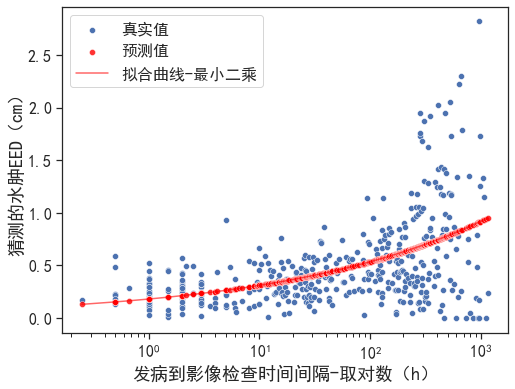

In [546]:
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_sorted_eed.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred, color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred, color='red', label='拟合曲线-最小二乘', alpha=0.6)

plt.xlabel("发病到影像检查时间间隔-取对数（h）", fontsize=18)
plt.ylabel("猜测的水肿EED（cm）", fontsize=18)
plt.xscale('log')

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('img/EED_最小二乘回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

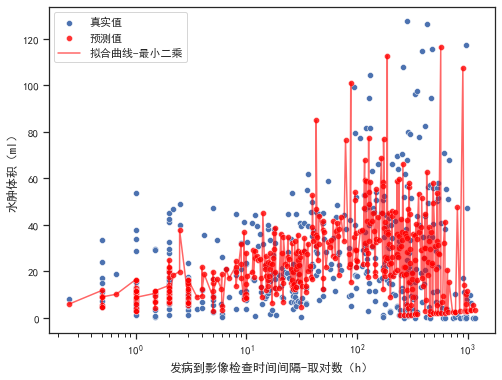

In [468]:
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time_formal_np.flatten(), y=vol_formal_np.flatten(), label='真实值')
sns.scatterplot(x=time_formal_np.flatten(), y=y_pred_vol, color='red', label='预测值', alpha=0.8)
plt.plot(time_formal_np.flatten(), y_pred_vol, color='red', label='拟合曲线-最小二乘', alpha=0.6)

# plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）")
plt.ylabel("水肿体积（ml）")
plt.xscale('log')
plt.legend()

plt.savefig('img/水肿拟合_EED回归.pdf', dpi=300, bbox_inches='tight')

plt.show()

### 峰值检测 PEAK（接到后面的分类）